In [2]:
import os
import glob
import pickle
import yaml

import numpy as np
import geopandas as gpd

import rasterio
from rasterio.plot import show
import rasterstats
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.colors as mplc

from utils.data_preprocessing import clean_region_name, landcover_stats_df
from utils.legends import *


with open("configs/config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
region_name = clean_region_name(config['study_region_name'])

# Get path to this file and then also path to data
dirname = os.getcwd()
data_path = os.path.join(dirname, 'data', region_name)
data_path2 = os.path.join(dirname, 'data', region_name, 'derived_from_DEM')
OSM_data_path = os.path.join(data_path, 'OSM_Infrastructure')

maps_dir = os.path.join(data_path, 'maps')
os.makedirs(maps_dir, exist_ok=True)

# Load the CRS
# geo CRS
with open(os.path.join(data_path, region_name+'_global_CRS.pkl'), 'rb') as file:
        global_crs_obj = pickle.load(file)
# projected CRS
with open(os.path.join(data_path, region_name+'_local_CRS.pkl'), 'rb') as file:
        local_crs_obj = pickle.load(file)

print(f'geo CRS: {global_crs_obj}; projected CRS: {local_crs_obj}')

# Extract tag for filename, e.g., 'EPSG3035' or 'ESRI102003'
auth = global_crs_obj.to_authority()
global_crs_tag = ''.join(auth) if auth else global_crs_obj.to_string().replace(":", "_")
auth = local_crs_obj.to_authority()
local_crs_tag = ''.join(auth) if auth else local_crs_obj.to_string().replace(":", "_")

regionPath = os.path.join(data_path, f'{region_name}_{local_crs_tag}.geojson')
region_boundary = gpd.read_file(regionPath)

geo CRS: EPSG:4326; projected CRS: EPSG:32632


# Roads, Railways, Airports (& Transmission lines)

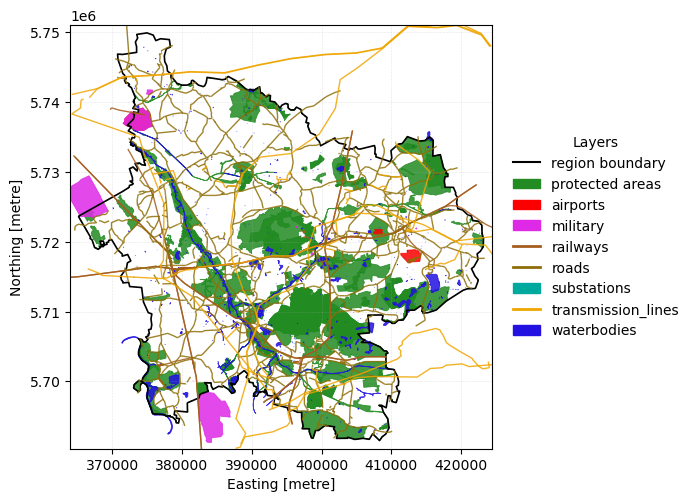

In [10]:
OSM_source = 'overpass'

# ------------------------------------------------------------------
# 0. Fixed colour scheme (your hex codes)
# ------------------------------------------------------------------
color_dict = {
    "roads"       : "#8e6f07",
    "airports"    : "#fa0000",
    "waterbodies" : "#2211e1",
    "military"    : "#de29e7",
    "railways"    : "#a65d1e",
    "transmission_lines": "#f0a500",
    "substations" : "#00a99d",
    "protected areas": "#228B22",
}
boundary_color = "#000000"   # black for the region outline

# ------------------------------------------------------------------
# 1. Region boundary → local_crs_obj
# ------------------------------------------------------------------
rb = (
    region_boundary.to_crs(local_crs_obj)
    if region_boundary.crs != local_crs_obj
    else region_boundary
)

# ------------------------------------------------------------------
# 2. Gather *.gpkg files
# ------------------------------------------------------------------
gpkg_files = glob.glob(os.path.join(OSM_data_path, f"{OSM_source}*.gpkg"))
# add protected areas (first entry of list since there should be only one file)
try:
    gpkg_files.insert(0, glob.glob(os.path.join(data_path, "*protected_areas*.gpkg"))[0])
except:
    pass

# Custom legend containers
handles, labels_seen = [], set()

# ------------------------------------------------------------------
# 3. Plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7))
rb.boundary.plot(ax=ax, edgecolor=boundary_color, linewidth=1.2, label='region boundary')
handles.append(Line2D([], [], color=boundary_color, linewidth=1.5, label='region boundary'))

for gpkg in gpkg_files:
    basename = os.path.basename(gpkg)
    if "protected_areas" in basename:
        layer_label = "protected areas"
    else:
        layer_label = os.path.splitext(os.path.basename(gpkg))[0].split('_', 1)[-1]

    # Skip unknown layers
    if layer_label not in color_dict:
        continue

    color = color_dict[layer_label]

    gdf = gpd.read_file(gpkg)
    if gdf.empty:
        continue
    if gdf.crs != local_crs_obj:
        gdf = gdf.to_crs(local_crs_obj)

    geom_type = gdf.geom_type.mode()[0]
    style = dict(color=color, alpha=0.85)

    if geom_type in ("LineString", "MultiLineString"):
        style["linewidth"] = 1
        gdf.plot(ax=ax, **style)
        if layer_label not in labels_seen:
            handles.append(Line2D([], [], color=color, linewidth=2, label=layer_label))

    elif geom_type in ("Point", "MultiPoint"):
        style["markersize"] = 20
        gdf.plot(ax=ax, **style)
        if layer_label not in labels_seen:
            handles.append(Line2D([], [], marker='o', linestyle='None',
                                  color=color, markersize=8, label=layer_label))

    else:  # Polygons / MultiPolygons
        style.update(edgecolor=color, linewidth=0.6)
        gdf.plot(ax=ax, **style)
        if layer_label not in labels_seen:
            handles.append(Patch(facecolor=color, edgecolor=color, label=layer_label))

    labels_seen.add(layer_label)

# ------------------------------------------------------------------
# 4. Map frame with coordinates
# ------------------------------------------------------------------
ax.set_aspect('equal')

# Show coordinate ticks and a subtle grid
ax.set_xlabel(f"Easting [{rb.crs.axis_info[0].unit_name}]" if rb.crs else "Easting")
ax.set_ylabel(f"Northing [{rb.crs.axis_info[0].unit_name}]" if rb.crs else "Northing")
ax.grid(which="both", linestyle=":", linewidth=0.4, alpha=0.6)

# Optional: tighten limits to the region with a small margin
xmin, ymin, xmax, ymax = rb.total_bounds
pad_x = (xmax - xmin) * 0.02
pad_y = (ymax - ymin) * 0.02
ax.set_xlim(xmin - pad_x, xmax + pad_x)
ax.set_ylim(ymin - pad_y, ymax + pad_y)

# Legend outside
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5),
          frameon=False, title="Layers")

output_path = os.path.join(maps_dir, f'OSM_features.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Raster files

# Landcover Analysis

In [3]:
#inspect land cover data
rasterRasterPath = os.path.join(data_path, f'landcover_openeo_colored_{region_name}_{local_crs_tag}.tif')
raster = rasterio.open(rasterRasterPath) 

band = raster.read(1, masked=True) #masked=True is masking no data values
meta = raster.meta
print(f'landcover EPSG: {raster.crs}')
print(f'bands (number of layers): {raster.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')

print(f'Pixel size (resolution): {raster.res}')  # (x_resolution, y_resolution)

band

landcover EPSG: EPSG:32633
bands (number of layers): 1
band shape: (8514, 8575)
number of Pixels: 73007550
Pixel size (resolution): (6.915236813897402, 6.915236813897402)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint8)

In [5]:
raster.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 8575, 'height': 8514, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'), 'transform': Affine(6.915236813897402, 0.0, 364328.6870154352,
       0.0, -6.915236813897402, 5750165.305716427), 'blockxsize': 8575, 'blockysize': 1, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

In [ ]:
# get land cover stats
pixel_size = raster.res[0]*raster.res[1]
df = landcover_stats_df(region_boundary, rasterRasterPath, legend_dict_esa_worldcover2021, pixel_size)
df

,category,code,count,area_km2
0,Bare / sparse vegetation,60,54339,3.0
1,Built-up,50,1165508,56.0
2,Cropland,40,12427137,594.0
3,Grassland,30,8923908,427.0
4,Herbaceous wetland,90,40907,2.0
5,Permanent water bodies,80,371647,18.0
6,Tree cover,10,16712115,799.0


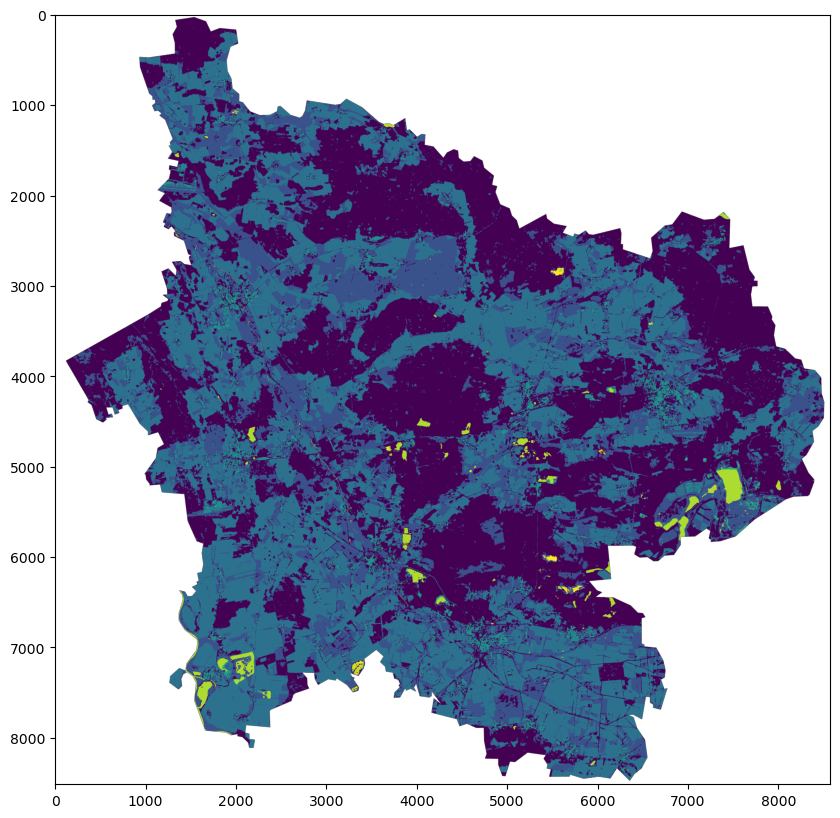

<Axes: >

In [ ]:
# Plot the data
#fig, ax = plt.subplots(figsize=(10, 10))
#show(band) #, cmap=landcover_cmap, vmin=20, vmax=len(colors))

#be careful with the coloring, it is not necessarily correct, there also might be some errors due to pixel size and coloring

In [31]:
band.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(8514, 8575), dtype=uint8)

In [32]:
raster.close()

# DEM

In [33]:
filename = f'DEM_{region_name}_{local_crs_tag}.tif'
raster = rasterio.open(os.path.join(data_path, filename)) 

band = raster.read(1, masked=True) #masked=True is masking no data values
meta = raster.meta
print(f'CRS: {raster.crs}')
print(f'bands (number of layers): {raster.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')

print(f'Pixel size (resolution): {raster.res}')  # (x_resolution, y_resolution)

band

CRS: EPSG:32633
bands (number of layers): 1
band shape: (171, 172)
number of Pixels: 29412
Pixel size (resolution): (345.8913992613987, 345.8913992613987)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-32767,
  dtype=int16)

In [34]:
print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', raster.meta['nodata'])

the minimum raster value is:  75
the maximum raster value is:  211
nodata value:  -32767.0


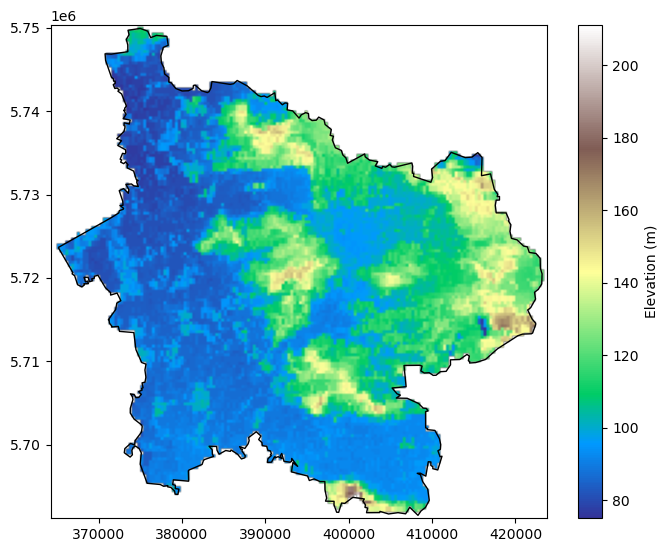

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'terrain'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Elevation (m)',shrink=0.8)

show(band, ax=ax, transform = raster.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

output_path = os.path.join(maps_dir, f'{filename.rsplit('.', 1)[0]}.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [36]:
def plot_elevations(above_below, height, band, ax):
    if above_below == 'below':   
        # Create the mask where values higher than height are masked (i.e., set to True)
        mask = (band > height) #| (band == dem.meta['nodata'])
    if above_below == 'above':   
        # Create the mask where values lower than height are masked (i.e., set to True)
        mask = (band < height) #| (band == dem.meta['nodata'])
    # Create the masked array
    masked_band = np.ma.masked_array(band, mask=mask)

    norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))

    cmap = 'terrain'
    show(masked_band, ax=ax, transform = raster.transform, cmap=cmap, norm=norm)
    ax.set_title(f'only heights {above_below}: {height}')

    # Add colorbar
    #fig.colorbar(im, ax=ax, orientation='vertical', label='Elevation (m)')
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Elevation (m)',shrink=0.8)




<Axes: title={'center': 'only heights above: 120'}>

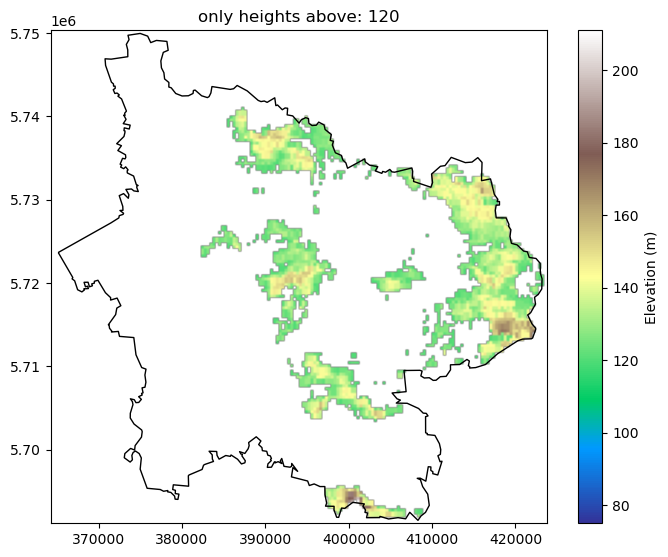

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_elevations('above', 120, band, ax)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

In [38]:
raster.close()

# Slope

CRS: EPSG:32633
bands (number of layers): 1
band shape: (171, 172)
number of Pixels: 29412
Pixel size (resolution): (345.8913992613987, 345.8913992613987)
the minimum raster value is:  0
the maximum raster value is:  5
nodata value:  -9999.0


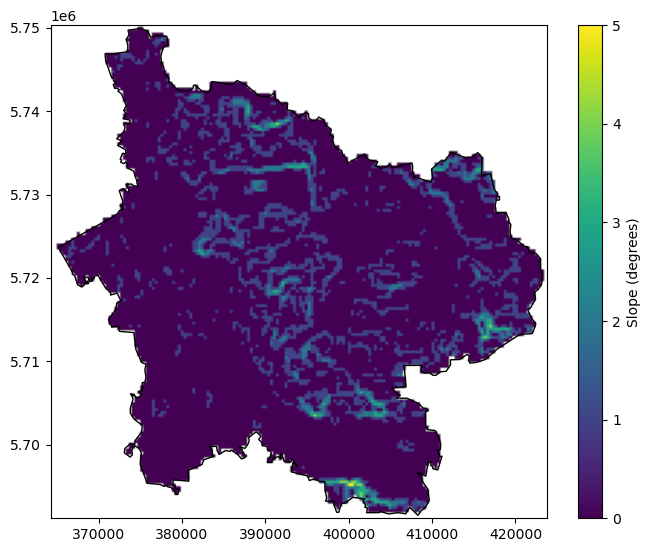

In [39]:
filename = f'slope_{region_name}_{local_crs_tag}.tif'
raster = rasterio.open(os.path.join(data_path2, filename)) 

band = raster.read(1, masked=True) #masked=True is masking no data values
meta = raster.meta
print(f'CRS: {raster.crs}')
print(f'bands (number of layers): {raster.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')

print(f'Pixel size (resolution): {raster.res}')  # (x_resolution, y_resolution)

print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', raster.meta['nodata'])

fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'viridis'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Slope (degrees)',shrink=0.8)

show(band, ax=ax, transform = raster.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

output_path = os.path.join(maps_dir, f'{filename.rsplit('.', 1)[0]}.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

raster.close()

# Aspect

CRS: EPSG:32633
bands (number of layers): 1
band shape: (171, 172)
number of Pixels: 29412
Pixel size (resolution): (345.8913992613987, 345.8913992613987)
the minimum raster value is:  0
the maximum raster value is:  359
nodata value:  -9999.0


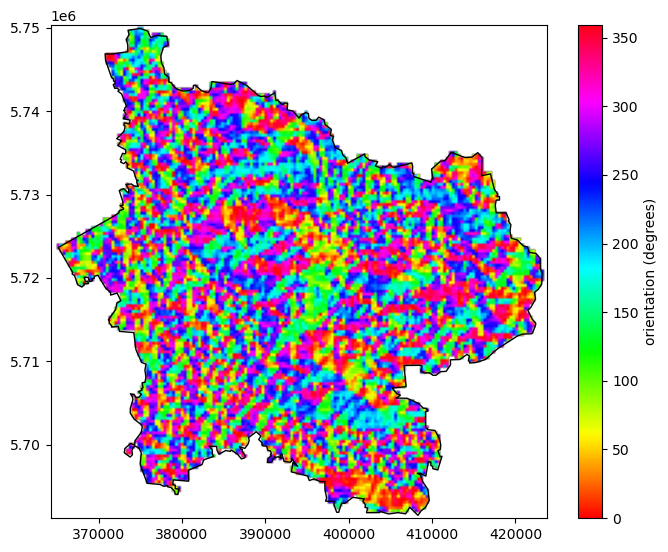

In [40]:
filename = f'aspect_{region_name}_{local_crs_tag}.tif'
raster = rasterio.open(os.path.join(data_path2, filename)) 

band = raster.read(1, masked=True) #masked=True is masking no data values
meta = raster.meta
print(f'CRS: {raster.crs}')
print(f'bands (number of layers): {raster.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')

print(f'Pixel size (resolution): {raster.res}')  # (x_resolution, y_resolution)

print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', raster.meta['nodata'])

fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'hsv'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='orientation (degrees)',shrink=0.8)

show(band, ax=ax, transform = raster.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

output_path = os.path.join(maps_dir, f'{filename.rsplit('.', 1)[0]}.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

raster.close()

# Solar

CRS: EPSG:32633
bands (number of layers): 1
band shape: (285, 287)
number of Pixels: 81795
Pixel size (resolution): (207.4155634944773, 207.4155634944773)
the minimum raster value is:  1066.165
the maximum raster value is:  1105.977
nodata value:  1.1754943508222875e-38


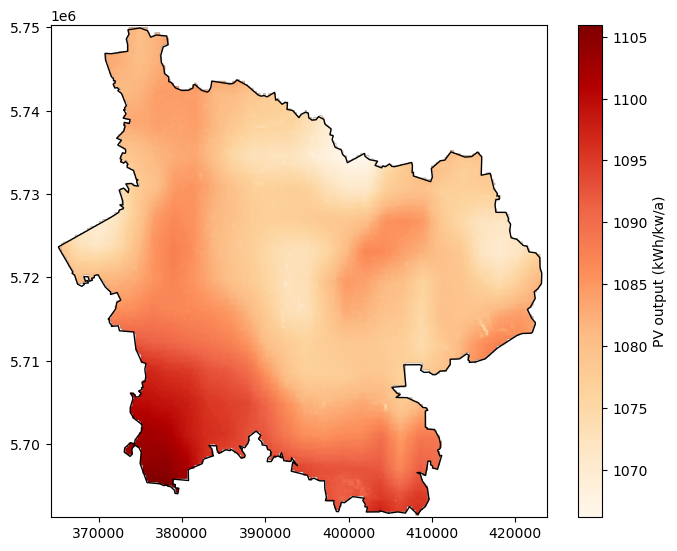

In [41]:
filename = f'solar_{region_name}_{local_crs_tag}.tif'
raster = rasterio.open(os.path.join(data_path, filename)) 

band = raster.read(1, masked=True) #masked=True is masking no data values
meta = raster.meta
print(f'CRS: {raster.crs}')
print(f'bands (number of layers): {raster.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')

print(f'Pixel size (resolution): {raster.res}')  # (x_resolution, y_resolution)

print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', raster.meta['nodata'])

fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'OrRd'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='PV output (kWh/kw/a)',shrink=0.8)

show(band, ax=ax, transform = raster.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

output_path = os.path.join(maps_dir, f'{filename.rsplit('.', 1)[0]}.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

raster.close()

# Wind

CRS: EPSG:32633
bands (number of layers): 1
band shape: (286, 287)
number of Pixels: 82082
Pixel size (resolution): (207.6358615098247, 207.6358615098247)
the minimum raster value is:  6.0423465
the maximum raster value is:  7.569665
nodata value:  nan


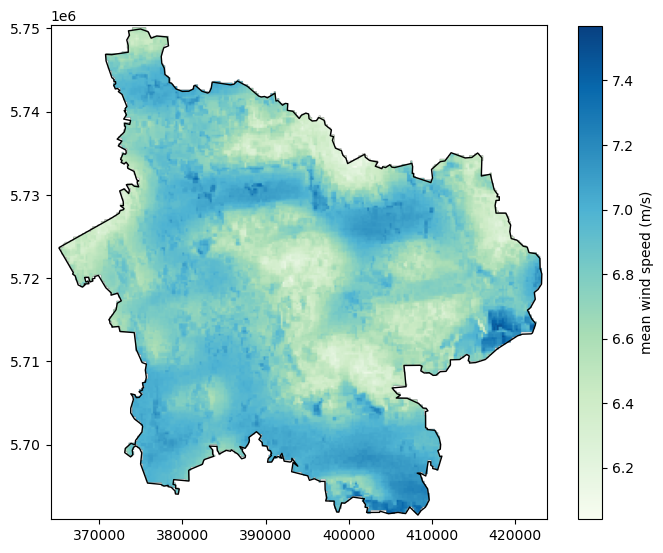

In [42]:
filename = f'wind_{region_name}_{local_crs_tag}.tif'
raster = rasterio.open(os.path.join(data_path, filename)) 

band = raster.read(1, masked=True) #masked=True is masking no data values
meta = raster.meta
print(f'CRS: {raster.crs}')
print(f'bands (number of layers): {raster.count}')

print(f'band shape: {band.shape}')
print(f'number of Pixels: {(band.shape[0]*band.shape[1])}')

print(f'Pixel size (resolution): {raster.res}')  # (x_resolution, y_resolution)

print("the minimum raster value is: ", band.min())
print("the maximum raster value is: ", band.max())
print('nodata value: ', raster.meta['nodata'])

fig, ax = plt.subplots(figsize=(8, 8))

cmap = 'GnBu'
norm = mplc.Normalize(vmin=np.nanmin(band), vmax=np.nanmax(band))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='mean wind speed (m/s)',shrink=0.8)

show(band, ax=ax, transform = raster.transform, cmap=cmap, norm=norm)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)

output_path = os.path.join(maps_dir, f'{filename.rsplit('.', 1)[0]}.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

raster.close()

# available land

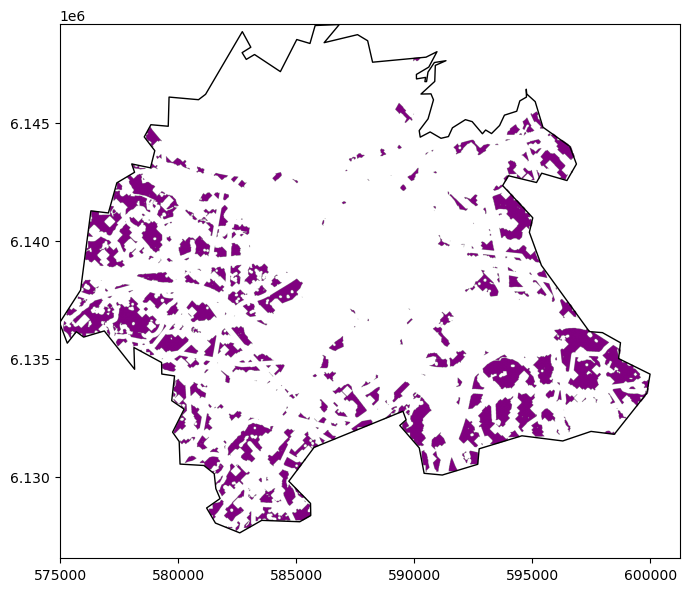

In [6]:
scenario = 'ref'
technology = 'solar'

filename = f'{region_name}_{technology}_{scenario}_available_land_{local_crs_tag}.tif'
raster = rasterio.open(os.path.join(data_path, 'available_land', filename)) 

band = raster.read(1, masked=True) #masked=True is masking no data values


fig, ax = plt.subplots(figsize=(8, 8))

# Create custom colormap: transparent for 0 (nodata), purple for 1 (available land)
from matplotlib.colors import ListedColormap
colors = ['none', 'purple']
cmap = ListedColormap(colors)

show(band, ax=ax, transform = raster.transform, cmap=cmap, vmin=0, vmax=1)
region_boundary.boundary.plot(ax=ax, edgecolor='k', linewidth=1)


raster.close()